# Introduction to DiffPrivLib

[DiffPrivLib](https://diffprivlib.readthedocs.io/en/latest/index.html) is a python library dedicated to differential privacy and machine learning. It is based on `scikit-learn` library. 

Some other [introduction notebooks](https://github.com/IBM/differential-privacy-library/tree/main/notebooks) are available directly in the official library repository.

## Step 1: Install the Library
Diffprivlib is available on pypi, it can be installed via the pip command. We will use the latest version of the library to date: version 0.6.6.

In [62]:
!pip install diffprivlib==0.6.6

Defaulting to user installation because normal site-packages is not writeable


## Step 2: Load and Prepare Data

### Load penguin dataset

In this notebook, we will work with the [penguin dataset]("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") from [seaborn datasets](https://github.com/mwaskom/seaborn-data).
We load the dataset via pandas in a dataframe `df`.

In [63]:
import pandas as pd

In [64]:
path_to_data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(path_to_data)

We can look at the first rows of the dataframe to get to know the data:

In [65]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Handle null values

DiffPrivLib does not allow null values so we will have to remove or convert them. For simplicity, we will just drop the rows with null values from the dataset.

In [66]:
print(f"{df.shape[0]} rows before dropping nulls")
df = df.dropna()
print(f"{df.shape[0]} rows after dropping nulls")

344 rows before dropping nulls
333 rows after dropping nulls


### Encode columns for Machine Learning

In the following analysis, we will use the `sex` column as a feature column. We encode the `MALE` and `FEMALE` strings in numbers that the models will the able to use.

In [67]:
df["sex"] = df["sex"].map({"MALE": 0, "FEMALE": 1})

In [68]:
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1


## Step 3: Logistic Regression with DiffPrivLib
We want to predict penguin's species based on bill length, bill depth, flipper length, body mass and sex.

Therefore, we will do a multiclass (there are 3 species) logistic regression.

We first split the data between features and target (to predict).

In [69]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
target_columns = ['species']

In [70]:
feature_data = df[feature_columns]
label_data = df[target_columns]

And then split the data to get a training and a testing set with the [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) from scikit-learn.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
TEST_SIZE = 0.2
RANDOM_STATE = 1 

x_train, x_test, y_train, y_test = train_test_split(
    feature_data,
    label_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
y_train = y_train.to_numpy().ravel()

Then we define the logistic regression pipeline [see doc](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#logistic-regression):

In [73]:
from diffprivlib import models

In [74]:
log_reg = models.LogisticRegression(epsilon = 1.0)

And fit it on the training set:

In [75]:
dpl_pipeline = log_reg.fit(x_train, y_train)

/home/bfs/.local/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


### Pipeline with logistic regression only (no standard scaler)

We see that we get a `PrivacyLeakWarning` warning (the light red text below the previous cell) because we did not specify the `data_norm` parameter. 

Differential privacy mechanisms need to know how much one individual’s record can change the model. This depends on the sensitivity of the loss function, which in turn depends on the size of feature vectors. `data_norm` is that bound: The maximum $L2$ norm of any single row (feature vector) in the dataset. 

If it is not specified, DiffPrivLib will infer if from the training data. This may leak information about the dataset (e.g. what the max value was), hence the PrivacyLeakWarning. To avoid that, we should decide on `data_norm` based on domain knowledge before looking at the data.

As common knowledge (without looking at the data), we know that:
- bill length $\in [30.0, 65.0]$,
- bill depth $\in [13.0, 23.0]$,
- flipper length $\in [150.0, 250.0]$,
- body mass $\in [2000.0, 7000.0]$,
- sex $\in [0, 1]$.

Formally, for a row $x = (x_1, \ldots, x_d)$, its L2 norm is $\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$.

The $L2$ norm of a row \(x\) can be bounded using the feature sensitivities:

$$
data\_norm = \sqrt{
(\text{bill length})^2 +
(\text{bill depth})^2 +
(\text{flipper length})^2 +
(\text{body mass})^2 +
(\text{sex})^2
}
$$

An upper bound on the maximum $L2$ norm of any row on the dataset is thus:
$$
data\_norm \leq \sqrt{
(\text{max bill length})^2 +
(\text{max bill depth})^2 +
(\text{max flipper length})^2 +
(\text{max body mass})^2 +
(\text{max sex})^2
}
$$


Writing it in a metadata dictionnary, we can then compute the `data_norm`:

In [76]:
import numpy as np

In [77]:
bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 250.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

In [78]:
# TODO: compute the data_norm
#sensitivities = ...
#data_norm = ...

# Correction
data_norm = np.sqrt(sum(v['upper']**2 for v in bounds.values()))
print("data_norm =", data_norm)

data_norm = 7004.802281292456


We rewrite the model pipeline with the `data_norm`

In [79]:
log_reg = models.LogisticRegression(epsilon = 1.0, data_norm=data_norm)

Fit it on the training set

In [80]:
log_reg = log_reg.fit(x_train, y_train)

And asses its score (mean accuracy) on the testing set [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [81]:
score = log_reg.score(x_test, y_test)
score

0.22388059701492538

Note: This is not DP but we can verify that our assumption for the data_norm was correct with:

In [82]:
# Not DP
true_max_data_norm = np.linalg.norm(feature_data, axis=1).max()  # Not DP
assert true_max_data_norm < data_norm, "There was an issue in the data_norm computation. Underestimated."

### Pipeline with standard scaler before logistic regression

In the previous model, we trained logistic regression without scaling, and we observed that features have very different ranges (e.g., body mass in thousands, sex as 0/1).  
This can cause the optimizer to converge slower, coefficients to be unbalanced, and, in the case of differential privacy, very large row norms that increase the amount of noise added.  

To address this, we will build a pipeline, where we first scale the data with a `StandardScaler` [(doc here)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#standard-scaler) and then fit a logistic regression. Scaling the features puts them on a similar range, improves optimization, and reduces row norms, which leads to better performance and more accurate differentially private estimates.

---

Unlike logistic regression, the `StandardScaler` does not take a `data_norm` parameter.  
Instead, it requires `bounds` for each feature in order to determine the sensitivity and calibrate the amount of noise to add.  

For a given feature, the sensitivity is defined as  

$$
sens = \text{max} - \text{min}.
$$

For example, consider the feature `bill_length_mm` with bounds:

$$
\text{min} = 30.0, \quad \text{max} = 65.0
$$

The sensitivity is  

$$
sens = 65.0 - 30.0 = 35.0
$$

If we use the Laplace mechanism, the privatized query for this feature would be  

$$
M(S) = q(S) + \text{Lap}\left(0, \frac{35.0}{\epsilon}\right)
$$

where $\epsilon$ is the privacy budget.

In [83]:
from sklearn.pipeline import Pipeline

In [84]:
def get_bounds(bounds, columns):
    lower = [bounds[col]["lower"] for col in columns]
    upper = [bounds[col]["upper"] for col in columns]
    return (lower, upper)

In [85]:
metadata_bounds = get_bounds(bounds, columns=feature_columns)
metadata_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

After scaling with `StandardScaler`, each feature is centered to mean 0 and scaled by its standard deviation. 

Based on the [68–95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), most values are mapped to [-3,3]. We take an even more conservative estimate with bounds between $[-4, 4]$. We can then compute an upper bound for `data_norm` using the new bounds of each scaled feature.

In [86]:
STD_BOUND = 4

In [87]:
scaled_data_norm = np.sqrt(sum(STD_BOUND**2 for i in range(len(feature_columns))))
print("scaled_data_norm:", scaled_data_norm)

scaled_data_norm: 8.94427190999916


Now fix this pipeline to avoid `PrivacyLeakWarning`

In [88]:
# TODO: Remove the privacy leak warning
#dpl_pipeline_with_scaler = Pipeline([
#    ('scaler', models.StandardScaler(epsilon = 0.5)),
#    ('classifier', models.LogisticRegression(epsilon = 1.0))
#])
#dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)

# Correction
dpl_pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=metadata_bounds)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm=scaled_data_norm))
])
dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)

And evaluating score of this new model:

In [89]:
# TODO: Evaluate the score of this new pipeline
#sc_score = ...

# Correction
sc_score = dpl_pipeline_with_scaler.score(x_test, y_test)
sc_score

0.417910447761194

Again, this is not DP but we can verify that most of the data was within the [-3, 3] bounds after the `Standard Scaler`

In [90]:
# Not DP
# Scale features
standard_scaler = models.StandardScaler(epsilon = 0.5, bounds=metadata_bounds)
scaled_feature_data = standard_scaler.fit_transform(feature_data)

# Percentage of values between -STD_BOUND and STD_BOUND
mask = (scaled_feature_data >= -STD_BOUND) & (scaled_feature_data <= STD_BOUND)  # Not DP
percentage = mask.sum() / scaled_feature_data.size * 100
print(f"Proportion of values between -{STD_BOUND} and {STD_BOUND}: {percentage}%")

Proportion of values between -4 and 4: 100.0%


### Privacy loss budget accountant

Another important parameter in DiffPrivLib is an `accountant`. It enables to track the spent budget accross multiple steps in a pipeline and/or accross multiple pipelines.

Therefore the same `accountant` instance of `BudgetAccountant` must be provided as input argument of the query. 

We rewrite here the previous pipeline with the `accountant`.

In [91]:
from diffprivlib import BudgetAccountant

In [92]:
accountant = BudgetAccountant()

dpl_pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=metadata_bounds, accountant=accountant)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm=scaled_data_norm, accountant=accountant))
])

With the `.total()` method, we can see the budget spent by the models. For now it was not fitted on the data so the budget is 0.

In [93]:
accountant.total()

(epsilon=0, delta=0.0)

We train the model on the data and check the budget again:

In [94]:
dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)
accountant.total()

(epsilon=1.5, delta=0.0)

As expected the budget from both steps is spent 0.5 + 1.0 = 1.5 epsilon.

### Use the model for prediction

We can use the model to predict a species depending on the feature values. 

We try to predict for three cases on female penguins:
- the smallest possible value for all features (lower bound)
- the biggest possible value for all features (upper bound)
- the medium value for all features

In [95]:
x_to_predict_dict = {}
for col in feature_columns:
    lower = bounds[col]['lower']
    upper = bounds[col]['upper']
    midpoint = (lower + upper) / 2
    x_to_predict_dict[col] = [lower, upper, midpoint]

x_to_predict = pd.DataFrame(x_to_predict_dict)
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,30.0,13.0,150.0,2000.0,0.0
1,65.0,23.0,250.0,7000.0,1.0
2,47.5,18.0,200.0,4500.0,0.5


In [96]:
predictions = dpl_pipeline_with_scaler.predict(x_to_predict)
x_to_predict["predictions"] = predictions
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,30.0,13.0,150.0,2000.0,0.0,Chinstrap
1,65.0,23.0,250.0,7000.0,1.0,Gentoo
2,47.5,18.0,200.0,4500.0,0.5,Adelie


## Step 4: Clustering KMeans

DiffPrivLib allows to use many other models. We will show here a second example with a `StandardScaler` followed by a `K-Means` clustering [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#k-means). 

We will do 6 clusters on the features 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g' and 'sex' and see which what cluster emerges. As it is unsupervised learning, there is no target column and we do not do a training and testing set.

In [97]:
N_CLUSTERS = 3

In [98]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
feature_data = df[feature_columns]

We determine the bound of the input data from the metadata:

In [99]:
metadata_bounds = get_bounds(bounds, columns=feature_columns)
metadata_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

For the bounds after the `StandardScaler` (which are inputs in `K-Means`), we follow the same reasoning as before and assume all data are within $[-3, 3]$:

In [100]:
after_std_bounds=([-STD_BOUND]*len(feature_columns), [STD_BOUND]*len(feature_columns))
after_std_bounds

([-4, -4, -4, -4, -4], [4, 4, 4, 4, 4])

### StandardScaler and KMeans

In [101]:
accountant = BudgetAccountant()

kmeans_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=metadata_bounds, accountant=accountant)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 5.0, bounds=after_std_bounds, accountant=accountant)),
])

Let's fit the K-Meand model on the clusters

In [102]:
# TODO: Fit the K-Mean pipeline
#kmeans_pipeline = ...

# Correction
kmeans_pipeline = kmeans_pipeline.fit(feature_data)
kmeans_pipeline

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,0.5
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...0), (5.0, 0)])"


We can look at the score of the model, which is the opposite of the value of X on the K-means objective.

In [103]:
kmeans_pipeline.score(feature_data)

-11190.195645858588

And use the model to predict the clusters:

In [104]:
# TODO: Predict clusters on feature_data with K-Mean pipeline
#predictions = ...

# Correction
predictions = kmeans_pipeline.predict(feature_data)

In [105]:
df["predictions"] = predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,1
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,1
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,0


We can plot the results to study the clusters

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
def plot_clusters(df, x, y, cluster_col="predictions", style_col="species"):
    """
    Plot two features colored by cluster predictions and shaped by species.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features, cluster predictions, and species.
    x : str
        Feature name for the x-axis.
    y : str
        Feature name for the y-axis.
    cluster_col : str, default="predictions"
        Column name with cluster assignments.
    style_col : str, default="species"
        Column name for marker style (e.g., species).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        style=style_col,
        palette="deep",
        s=80
    )
    plt.title(f"DP KMeans Clustering: {x} vs {y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

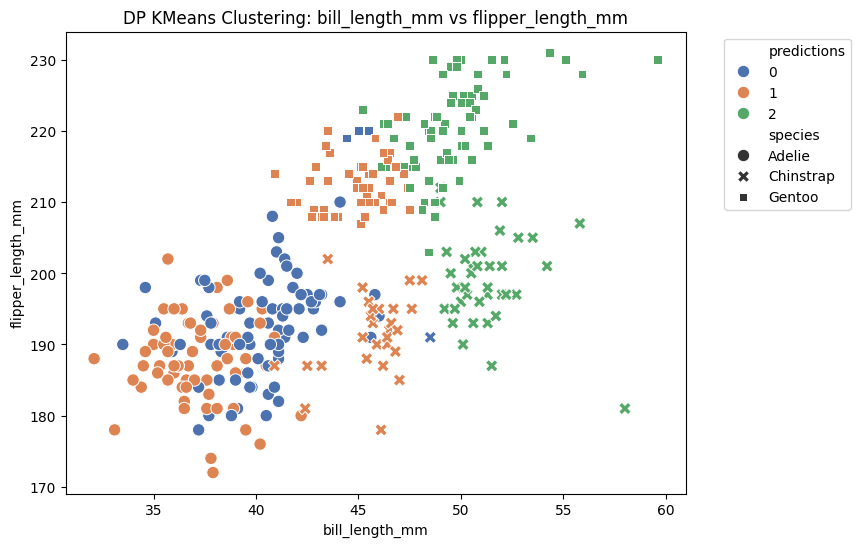

In [108]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm")

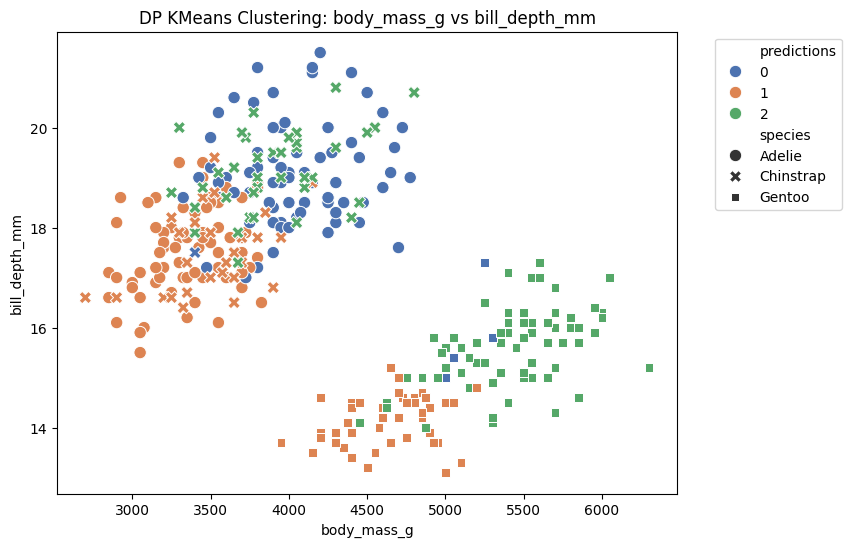

In [109]:
plot_clusters(df, x="body_mass_g", y="bill_depth_mm")

Feel free to try various number of cluster options, feature selection and axis to plot!

### KMeans after PCA and StandardScaler

Let's try do do a dimensionality reduction to two components with a PCA before K-Means to improve the clustering.

In [110]:
N_COMPONENTS = 2

In [111]:
scaled_data_norm = np.sqrt(sum(STD_BOUND**2 for i in range(len(feature_columns))))
print("scaled_data_norm:", scaled_data_norm)

scaled_data_norm: 8.94427190999916


In [117]:
accountant = BudgetAccountant()

pca_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 1.0, bounds=metadata_bounds, accountant=accountant)),
    ('pca', models.PCA(n_components=N_COMPONENTS, epsilon=2.0, bounds=after_std_bounds, data_norm=scaled_data_norm, accountant=accountant)),
])

We use [fit transform](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.PCA.fit_transform) to fit the model with feature_data and apply directly the dimensionality reduction on it.

In [118]:
pca_feature_data = pca_pipeline.fit_transform(feature_data)
pca_feature_data.shape

(333, 2)

This outputs 2 columns that we add to our dataframe.

In [119]:
df[["pca_1", "pca_2"]] = pd.DataFrame(pca_feature_data, index=df.index)
df.head(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,pca_1,pca_2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0,-1.838056,-0.921725


We now want to train a K-Means clustering on the principal components.  
Once again, we need to determine bounds for the data output of PCA and the input of K-Means.  

After scaling, each feature is roughly within [-STD_BOUND, STD_BOUND], and we can computed the maximum L2 norm of any row as $data\_norm \leq \sqrt{(\text{max bill length})^2 +(\text{max bill depth})^2 +(\text{max flipper length})^2 +(\text{max body mass})^2 +(\text{max sex})^2}$

PCA is a linear transformation (rotation and projection) of the scaled data.  
- Importantly, a rotation does not increase the L2 norm of a vector.  
- Therefore, the L2 norm of each row in the PCA space is **at most equal** to `scaled_data_norm`.  

This means we can safely set conservative bounds for K-Means along each principal component as:
$$
after\_pca\_bounds \leq [-\text{scaled\_data\_norm}, \text{scaled\_data\_norm}]
$$

In [120]:
after_pca_bounds = ([-scaled_data_norm]*2, [scaled_data_norm]*2)

One more time, it is not DP, but we can verify our bounds:

In [121]:
# Not DP
# Get min and max per PCA component
pca_mins = df[["pca_1", "pca_2"]].min()  # Not DP
pca_maxs = df[["pca_1", "pca_2"]].max()  # Not DP

for i, col in enumerate(["pca_1", "pca_2"]):
    assert pca_mins[col] > after_pca_bounds[0][i], f"{col} has values below lower bound"
    assert pca_maxs[col] < after_pca_bounds[1][i], f"{col} has values above upper bound"    

We now instantiate the `K-Means` model:

In [122]:
kmeans_model = models.KMeans(n_clusters = N_CLUSTERS, epsilon = 2.0, bounds=after_pca_bounds, accountant=accountant)

Fit in on the pca data:

In [123]:
# TODO: fit kmean on principal components
#kmeans_model = ...

# Correction
kmeans_model = kmeans_model.fit(df[["pca_1", "pca_2"]])
kmeans_model

,n_clusters,3
,epsilon,2.0
,bounds,"(array([-8.944... -8.94427191]), ...)"
,random_state,None
,accountant,"BudgetAccount...0), (2.0, 0)])"


And make predictions:

In [124]:
# TODO: Predict clusters on principal compoents with K-Mean pipeline
#predictions = ...

# Correction
after_pca_predictions = kmeans_model.predict(df[["pca_1", "pca_2"]])

In [125]:
df["after_pca_predictions"] = after_pca_predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,pca_1,pca_2,after_pca_predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0,-1.838056,-0.921725,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,1,-2.203258,0.715221,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,1,-3.201241,0.271221,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,1,-2.911910,0.007423,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,0,-2.084275,-1.401947,0


We can plot the clusters:

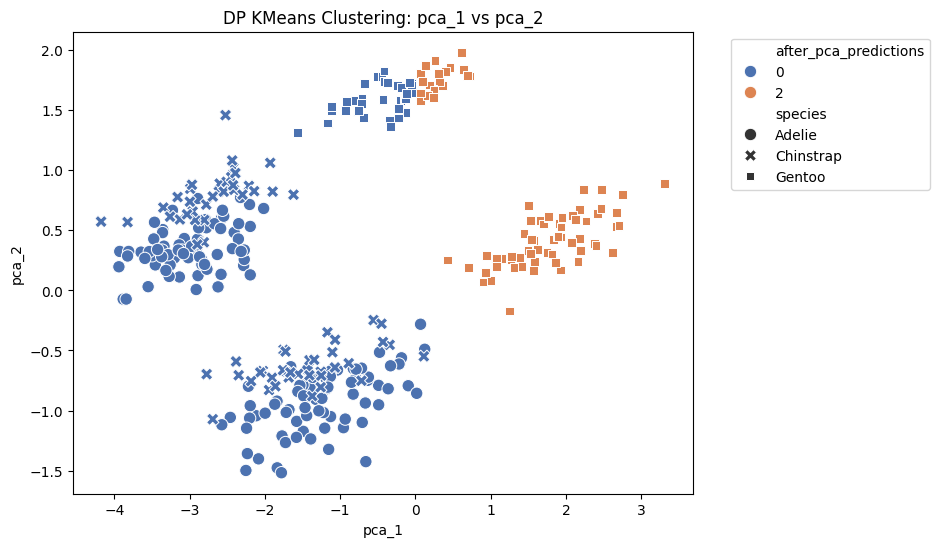

In [126]:
plot_clusters(df, x="pca_1", y="pca_2", cluster_col="after_pca_predictions")

Again, feel free to try various number of principal components, cluster options, feature selection and axis to plot!

Let's now check what was the total budget spent by the scaler, pca and k-means models.

In [127]:
# TODO: Get epsilon and delta
# Correction
accountant.total()

(epsilon=5.0, delta=0.0)